See README.md for installs, environment setup

In [1]:
import sys
from multiprocessing import Pool
from datetime import datetime

import numpy as np
import pandas as pd
import pandas_datareader as pdr
import xlrd

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# https://www.cvxpy.org/install/index.html
import cvxpy as cp

# set seed for reproducibility
np.random.seed(2347)

print("%-20s %s" % ('python', ".".join(map(str, sys.version_info[:3]))))
print("%-20s %s" % ("numpy", np.__version__))
print("%-20s %s" % ("pandas", pd.__version__))
print("%-20s %s" % ("pandas-datareader", pdr.__version__))
# print("%-20s %s" % ("xlrd", xlrd.__version__))
print("%-20s %s" % ("seaborn", sns.__version__))
print("%-20s %s" % ("matplotlib", matplotlib.__version__))
print("%-20s %s" % ("cvxpy", cp.__version__))


python               3.7.10
numpy                1.19.2
pandas               1.1.3
pandas-datareader    0.9.0
seaborn              0.11.0
matplotlib           3.3.4
cvxpy                1.1.7


# Get data

In [2]:
# load spreadsheet from Damodaran website into pandas dataframe
data_xls = 'http://www.stern.nyu.edu/~adamodar/pc/datasets/histretSP.xls'
data_sheet = "Returns by year"
# these will change as rows get added on Damodaran website
skiprows = range(17)
skipfooter = 10
download_df = pd.read_excel('http://www.stern.nyu.edu/~adamodar/pc/datasets/histretSP.xls', 
                         sheet_name=data_sheet, 
                         skiprows=skiprows,
                         skipfooter=skipfooter)
download_df = download_df.set_index('Year')

In [3]:
download_df

,S&P 500 (includes dividends),3-month T.Bill,US T. Bond,Baa Corporate Bond,S&P 500 (includes dividends)3,3-month T.Bill4,US T. Bond5,Baa Corporate Bond6,Stocks - Bills,Stocks - Bonds,Stocks - Baa Corp Bond,Historical risk premium,Inflation Rate,S&P 500 (includes dividends)2,3-month T. Bill (Real),!0-year T.Bonds,Baa Corp Bonds
Year,,,,,,,,,,,,,,,,,
1928,0.438112,0.030800,0.008355,0.032196,143.811155,103.080000,100.835471,103.219551,0.407312,0.429757,0.405916,NaN,-0.011522,0.454874,0.042815,0.020108,0.044227
1929,-0.082979,0.031600,0.042038,0.030179,131.877782,106.337328,105.074397,106.334569,-0.114579,-0.125018,-0.113158,NaN,0.000000,-0.082979,0.031600,0.042038,0.030179
1930,-0.251236,0.045500,0.045409,0.005398,98.745288,111.175676,109.845753,106.908543,-0.296736,-0.296646,-0.256634,NaN,-0.026712,-0.230686,0.074194,0.074101,0.032991
1931,-0.438375,0.023100,-0.025589,-0.156808,55.457774,113.743835,107.034958,90.144455,-0.461475,-0.412787,-0.281568,NaN,-0.089321,-0.383290,0.123448,0.069984,-0.074106
1932,-0.086424,0.010700,0.087903,0.235896,50.664911,114.960894,116.443660,111.409173,-0.097124,-0.174327,-0.322320,NaN,-0.103014,0.018495,0.126773,0.212842,0.377832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,0.117731,0.003175,0.006906,0.103651,328742.282302,1990.703714,7110.653529,39552.738791,0.114556,0.110825,0.014080,0.046177,0.012616,0.103805,-0.009323,-0.005639,0.089901
2017,0.216055,0.009308,0.028017,0.097239,399768.635072,2009.233848,7309.873866,43398.808328,0.206746,0.188038,0.118816,0.047687,0.021301,0.190692,-0.011743,0.006576,0.074354
2018,-0.042269,0.019392,-0.000167,-0.027626,382870.937409,2048.196241,7308.653674,42199.860601,-0.061660,-0.042102,-0.014642,0.046609,0.024426,-0.065104,-0.004914,-0.024006,-0.050811


In [4]:
# load gold data from FRED API & save copy locally to CSV file

series = ['GOLDAMGBD228NLBM']

gold_temp = pdr.data.DataReader(series, 
                                'fred', 
                                start='1968-12-31')
# convert daily to annual
gold_temp = gold_temp.resample('A').last().reset_index()
gold_temp.set_index(pd.DatetimeIndex(gold_temp['DATE']).year, inplace=True)
gold_temp['return'] = gold_temp['GOLDAMGBD228NLBM'].pct_change()

# line up dates
gold_download = pd.DataFrame(index=download_df.index)
gold_download['gold'] = gold_temp['return']

gold_download.to_csv('gold_fred.csv')


In [5]:
gold_download

,gold
Year,
1928,NaN
1929,NaN
1930,NaN
1931,NaN
1932,NaN
...,...
2016,0.091174
2017,0.118540
2018,-0.011454


In [6]:
# splice older gold data from other sources (Ibbotson yearbook)
longrun_data = pd.DataFrame({'year': list(range(1928, 2021)), 'gold': [0,0,0,0,0,0.563618771,0.082920792,0,0,0,0,0,-0.014285714,0.028985507,0,0.028169014,-0.006849315,0.027586207,0.026845638,0.124183007,-0.023255814,-0.035714286,-0.00617284,-0.00621118,-0.0325,-0.082687339,-0.007042254,-0.002836879,0.001422475,0.001420455,0,0,0.035460993,-0.02739726,-0.004225352,-0.002828854,0.002836879,0.004243281,-0.002816901,0.002824859,0.225352113,-0.057471264,-0.051219512,0.146529563,0.431390135,0.667919799,0.725864012,-0.242041683,-0.03962955,0.204305898,0.291744258,1.205670351,0.296078431,-0.327618087,0.1175,-0.149888143,-0.189473684,0.061688312,0.195412844,0.244563827,-0.156937307,-0.022308911,-0.036907731,-0.085577421,-0.057057907,0.176426426,-0.021697511,0.009784736,-0.046511628,-0.222086721,0.005748128,0.005368895,-0.060637382,0.014120668,0.23960217,0.217359592,0.04397843,0.17768595,0.231968811,0.319224684,0.043178411,0.250359299,0.292413793,0.089292067,0.082625735,-0.273303167,0.00124533,-0.114238,0.091174,0.118540,-0.011454,0.188312, 0.241694]})
longrun_data.set_index('year', inplace=True)
longrun_data


,gold
year,
1928,0.000000
1929,0.000000
1930,0.000000
1931,0.000000
1932,0.000000
...,...
2016,0.091174
2017,0.118540
2018,-0.011454


In [7]:
gold_download.loc[1928:1968, 'gold'] = longrun_data['gold']
gold_download

,gold
Year,
1928,0.000000
1929,0.000000
1930,0.000000
1931,0.000000
1932,0.000000
...,...
2016,0.091174
2017,0.118540
2018,-0.011454


In [8]:
series = ['GDPCA']

gdp_download = pdr.data.DataReader(series, 
                                   'fred', 
                                   start='1926-12-31')
gdp_download.reset_index(inplace=True)
gdp_download.set_index(pd.DatetimeIndex(gdp_download['DATE']).year, inplace=True)
gdp_download['GDP'] = gdp_download['GDPCA'].pct_change()
# https://fortunly.com/statistics/us-gdp-by-year-guide/#gref
gdp_download.loc[1928, 'GDP'] = 0.0110
gdp_download.loc[1929, 'GDP'] = 0.0652
gdp_download.sort_index(inplace=True)
gdp_download.to_csv('gdp_fred.csv')

gdp_download

,DATE,GDPCA,GDP
DATE,,,
1928,NaT,NaN,0.011000
1929,1929-01-01,1109.448,0.065200
1930,1930-01-01,1015.058,-0.085078
1931,1931-01-01,950.037,-0.064056
1932,1932-01-01,827.495,-0.128987
...,...,...,...
2016,2016-01-01,17730.509,0.017114
2017,2017-01-01,18144.105,0.023327
2018,2018-01-01,18687.786,0.029965


In [9]:
data_df = download_df.copy()
data_df = data_df.rename(columns = {'Inflation Rate': 'CPI',
           'S&P 500 (includes dividends)2': 'S&P',
           '3-month T. Bill (Real)': 'T-Bills',
           '!0-year T.Bonds': 'T-Notes',
           'Baa Corp Bonds': 'Baa Corps',
          })[['CPI', 'S&P', 'T-Bills', 'T-Notes', 'Baa Corps']]
data_df["GDP"] = gdp_download['GDP']
data_df["Gold"] = gold_download['gold'] - data_df['CPI']
# reorder
data_df = data_df[['GDP', 'CPI', 'S&P', 'T-Bills', 'T-Notes', 'Baa Corps', 'Gold']]


# Visualize

In [10]:
df = data_df
df

,GDP,CPI,S&P,T-Bills,T-Notes,Baa Corps,Gold
Year,,,,,,,
1928,0.011000,-0.011522,0.454874,0.042815,0.020108,0.044227,0.011522
1929,0.065200,0.000000,-0.082979,0.031600,0.042038,0.030179,0.000000
1930,-0.085078,-0.026712,-0.230686,0.074194,0.074101,0.032991,0.026712
1931,-0.064056,-0.089321,-0.383290,0.123448,0.069984,-0.074106,0.089321
1932,-0.128987,-0.103014,0.018495,0.126773,0.212842,0.377832,0.103014
...,...,...,...,...,...,...,...
2016,0.017114,0.012616,0.103805,-0.009323,-0.005639,0.089901,0.078559
2017,0.023327,0.021301,0.190692,-0.011743,0.006576,0.074354,0.097239
2018,0.029965,0.024426,-0.065104,-0.004914,-0.024006,-0.050811,-0.035880


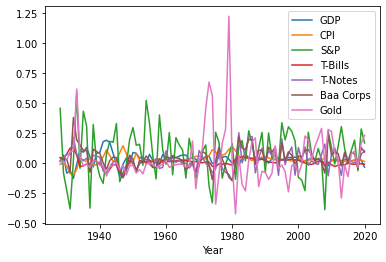

In [11]:
df.plot.line();


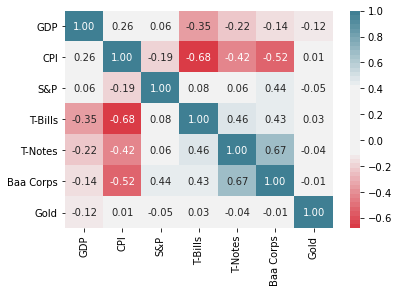

In [12]:
# compute correlation matrix
my_cmap = sns.diverging_palette(10, 220, sep=80, n=50)
sns.heatmap(df.corr(), annot=True, fmt=".02f", cmap=my_cmap);


In [13]:
# drop CPI, GDP which are not assets
df.drop(labels=['CPI', 'GDP'], axis=1, inplace=True)
# drop T-Notes, allocations are small, favors corps 
# df.drop(labels=['T-Notes'], axis=1, inplace=True)
labels = list(df.columns)
labels


['S&P', 'T-Bills', 'T-Notes', 'Baa Corps', 'Gold']

# Long-only optimization

In [14]:
df

,S&P,T-Bills,T-Notes,Baa Corps,Gold
Year,,,,,
1928,0.454874,0.042815,0.020108,0.044227,0.011522
1929,-0.082979,0.031600,0.042038,0.030179,0.000000
1930,-0.230686,0.074194,0.074101,0.032991,0.026712
1931,-0.383290,0.123448,0.069984,-0.074106,0.089321
1932,0.018495,0.126773,0.212842,0.377832,0.103014
...,...,...,...,...,...
2016,0.103805,-0.009323,-0.005639,0.089901,0.078559
2017,0.190692,-0.011743,0.006576,0.074354,0.097239
2018,-0.065104,-0.004914,-0.024006,-0.050811,-0.035880


In [15]:
# compute covariance matrix
Sigma = np.cov(df.transpose())
# number of assets

n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T @ w 
# volatility
vol = cp.quad_form(w, Sigma)

z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

,S&P,T-Bills,T-Notes,Baa Corps,Gold
rows,,,,,
real return,0.085008,0.004174,0.022511,0.042692,0.037508
vol,0.195308,0.035575,0.081235,0.085938,0.214255


In [16]:
w

Variable((5,))

In [17]:
Sigma

array([[ 0.03814539,  0.00054112,  0.00093293,  0.00735792, -0.00199526],
       [ 0.00054112,  0.00126561,  0.00134353,  0.00132341,  0.00024363],
       [ 0.00093293,  0.00134353,  0.00659916,  0.00468082, -0.00070777],
       [ 0.00735792,  0.00132341,  0.00468082,  0.00738529, -0.00014026],
       [-0.00199526,  0.00024363, -0.00070777, -0.00014026,  0.04590507]])

In [18]:
# Solve max return portfolio (corner solution)
prob = cp.Problem(cp.Maximize(ret), 
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxret = ret.value
print("Max return portfolio weights")
pd.DataFrame([wts], columns=labels)


Max return portfolio weights


,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,1.0,0.0,0.0,0.0,0.0


In [19]:
# solve min vol portfolio (other corner solution)
prob = cp.Problem(cp.Minimize(vol),
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
# round to not get x.xxxxE-22
wts = [float('%0.6f' % v) for v in w.value]

minvol = vol.value
minvolret = ret.value
print("Min vol portfolio weights")
pd.DataFrame([wts], columns=labels)


Min vol portfolio weights


,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,0.019792,0.957674,-0.0,-0.0,0.022534


In [20]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   w >= 0,
                   vol <= vol_limit
                  ]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


CPU times: user 392 ms, sys: 4.25 ms, total: 396 ms
Wall time: 394 ms


In [21]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]
ret_df

,i,vol,return,std,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,0,0.001228,0.006531,0.035046,0.019850,9.575949e-01,2.499813e-07,8.252234e-08,2.255480e-02
1,1,0.001414,0.013572,0.037600,0.061061,7.976187e-01,3.766443e-02,6.093312e-02,4.272285e-02
2,2,0.001599,0.016736,0.039991,0.073993,7.249385e-01,4.463350e-02,1.057481e-01,5.068725e-02
3,3,0.001785,0.019180,0.042247,0.083978,6.688233e-01,4.999599e-02,1.403665e-01,5.683637e-02
4,4,0.001970,0.021246,0.044388,0.092419,6.213576e-01,5.460070e-02,1.695839e-01,6.203876e-02
...,...,...,...,...,...,...,...,...,...
195,195,0.037403,0.084565,0.193399,0.990661,8.664189e-09,1.712727e-08,5.514136e-08,9.338752e-03
196,196,0.037589,0.084676,0.193878,0.993014,7.931506e-09,1.561844e-08,4.974340e-08,6.985843e-03
197,197,0.037774,0.084787,0.194356,0.995355,1.787006e-08,3.512108e-08,1.107687e-07,4.645136e-03
198,198,0.037960,0.084898,0.194833,0.997683,3.662064e-09,7.076601e-09,2.054937e-08,2.316658e-03


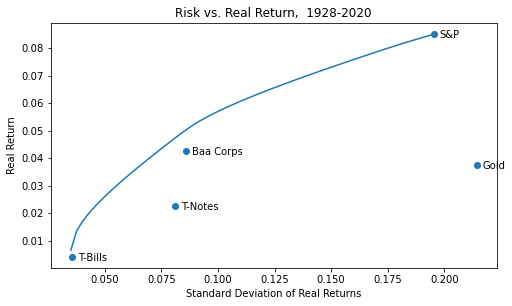

In [22]:
# plot efficient frontier
def plot_efrontier(ret_df, df,
                   xlabel="Standard Deviation of Real Returns",
                   ylabel="Real Return",
                   title=None):

    Sigma = np.cov(df.transpose())
    n = Sigma.shape[0]
    mu = df.mean().values
    asset_vols = np.sqrt(Sigma.diagonal())

    plt.figure(figsize=(8, 4.5))

    # plot the data
    plt.plot(ret_df['std'], ret_df['return'])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plot_title = "Risk vs. Real Return,  %d-%d" % (df.index[0], df.index[-1]) if title is None else title
    plt.title(plot_title)

    # plot the markers
    plt.scatter(asset_vols, mu)
    xoffset = 0.0025
    yoffset = 0.0015
    labels = df.columns
    for i, label in enumerate(labels):
        plt.annotate(label, xy=(asset_vols[i]+xoffset, mu[i]+yoffset),  xycoords='data',
                     horizontalalignment='left', verticalalignment='top',
                    )
        
plot_efrontier(ret_df, df)


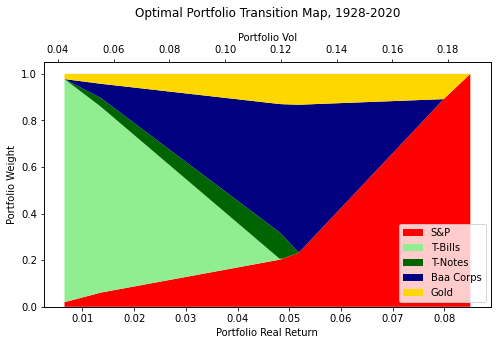

In [23]:
# stacked area chart of weights vs. returns
# for given vol constraint and corresponding real return, show portfolio weights
def transition_map(ret_df, labels, startyear, endyear):
    
    x = ret_df['return']
    # absolute values so shorts don't create chaos
    y_list = [abs(ret_df[l]) for l in labels]
    pal = ['red', 'lightgreen', 'darkgreen', 'navy', 'gold', 'cyan']
    
    fig = plt.figure(figsize=(8, 4.5))
    ax1 = fig.add_subplot(111)

    ax1.stackplot(x, y_list, labels=labels, colors=pal)
    ax1.set_xlabel("Portfolio Real Return")
    ax1.set_ylabel("Portfolio Weight")
    ax1.legend(loc='lower right')
    ax2 = ax1.twiny()
    ax2.set_xlim((ret_df['std'].iloc[0], ret_df['std'].iloc[-1]))
    ax2.set_xlabel('Portfolio Vol')
    
    
    plt.title("Optimal Portfolio Transition Map, %d-%d" % (startyear, endyear), y=1.16);

transition_map(ret_df, labels=df.columns, startyear=df.index[0], endyear=df.index[-1])

## 1972 - present (post gold standard)

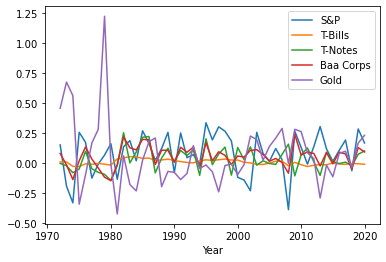

In [24]:
df = data_df.loc[1972:]
df.plot.line();


In [25]:
# compute covariance matrix
Sigma = np.cov(df.transpose())
# number of assets

n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T @ w 
# volatility
vol = cp.quad_form(w, Sigma)

z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

,S&P,T-Bills,T-Notes,Baa Corps,Gold
rows,,,,,
real return,0.080523,0.005910,0.032854,0.054728,0.069764
vol,0.168004,0.021665,0.095506,0.086642,0.272478


In [26]:
# Solve max return portfolio (corner solution)
prob = cp.Problem(cp.Maximize(ret), 
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxret = ret.value
print("Max return portfolio weights")
pd.DataFrame([wts], columns=labels)


Max return portfolio weights


,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,1.0,0.0,0.0,0.0,0.0


In [27]:
# solve min vol portfolio (other corner solution)
prob = cp.Problem(cp.Minimize(vol),
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]

minvol = vol.value
minvolret = ret.value
print("Min vol portfolio weights")
pd.DataFrame([wts], columns=labels)


Min vol portfolio weights


,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,-0.0,0.9731,-0.0,-0.0,0.0269


In [28]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   w >= 0,
                   vol <= vol_limit
                  ]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


CPU times: user 404 ms, sys: 5.05 ms, total: 409 ms
Wall time: 406 ms


In [29]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]
ret_df

,i,vol,return,std,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,0,0.000413,0.007626,0.020325,3.261171e-08,9.731211e-01,1.165286e-08,9.972902e-09,2.687883e-02
1,1,0.000553,0.015141,0.023513,3.147045e-02,8.417322e-01,1.267207e-03,7.761244e-02,4.791767e-02
2,2,0.000693,0.018674,0.026318,4.231161e-02,7.766458e-01,3.891841e-03,1.203220e-01,5.682881e-02
3,3,0.000832,0.021402,0.028851,5.066910e-02,7.264153e-01,5.874776e-03,1.533327e-01,6.370810e-02
4,4,0.000972,0.023708,0.031179,5.773436e-02,6.839781e-01,7.525620e-03,1.812418e-01,6.952010e-02
...,...,...,...,...,...,...,...,...,...
195,195,0.027666,0.080444,0.166332,9.926267e-01,9.766679e-10,1.640180e-09,3.458815e-09,7.373268e-03
196,196,0.027806,0.080464,0.166752,9.944866e-01,1.237861e-09,2.067262e-09,4.277507e-09,5.513371e-03
197,197,0.027946,0.080484,0.167170,9.963353e-01,1.939357e-09,3.237882e-09,6.648859e-09,3.664678e-03
198,198,0.028086,0.080504,0.167588,9.981730e-01,2.590618e-09,4.350124e-09,8.920725e-09,1.826980e-03


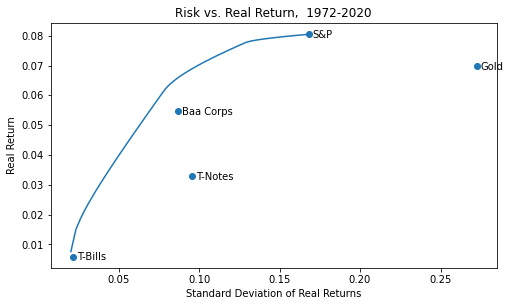

In [30]:
plot_efrontier(ret_df, df)


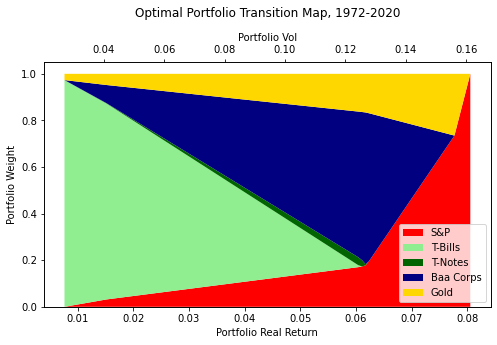

In [31]:
transition_map(ret_df, labels=df.columns, startyear=df.index[0], endyear=df.index[-1])

## 1983 - present (post-inflation era)


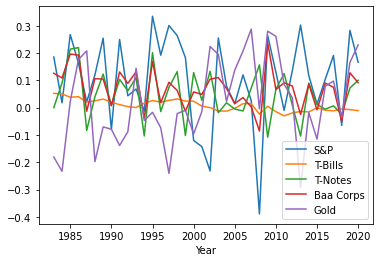

In [32]:
df = data_df.loc[1983:]
df.plot.line();

In [33]:
# compute covariance matrix
Sigma = np.cov(df.transpose())
# number of assets

n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T @ w 
# volatility
vol = cp.quad_form(w, Sigma)

z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

,S&P,T-Bills,T-Notes,Baa Corps,Gold
rows,,,,,
real return,0.100221,0.008165,0.047613,0.070724,0.023219
vol,0.159669,0.020938,0.087461,0.071155,0.155898


In [34]:
# Solve max return portfolio (corner solution)
prob = cp.Problem(cp.Maximize(ret), 
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxret = ret.value
print("Max return portfolio weights")
pd.DataFrame([wts], columns=labels)


Max return portfolio weights


,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,1.0,0.0,0.0,0.0,0.0


In [35]:
# solve min vol portfolio (other corner solution)
prob = cp.Problem(cp.Minimize(vol),
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]

minvol = vol.value
minvolret = ret.value
print("Min vol portfolio weights")
pd.DataFrame([wts], columns=labels)


Min vol portfolio weights


,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,-0.0,0.9395,0.0029,-0.0,0.0575


In [36]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   w >= 0,
                   vol <= vol_limit
                  ]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


CPU times: user 386 ms, sys: 5.31 ms, total: 391 ms
Wall time: 388 ms


In [37]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]
ret_df


,i,vol,return,std,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,0,0.000348,0.009150,0.018668,1.347515e-08,9.394573e-01,3.016828e-03,3.047113e-08,5.752580e-02
1,1,0.000475,0.018010,0.021791,1.357025e-02,7.962907e-01,3.828159e-02,1.010359e-01,5.082161e-02
2,2,0.000601,0.022360,0.024519,2.087917e-02,7.292950e-01,4.873822e-02,1.541470e-01,4.694065e-02
3,3,0.000728,0.025721,0.026973,2.655954e-02,6.774892e-01,5.687236e-02,1.951065e-01,4.397240e-02
4,4,0.000854,0.028563,0.029222,3.135399e-02,6.337007e-01,6.373281e-02,2.297636e-01,4.144887e-02
...,...,...,...,...,...,...,...,...,...
195,195,0.024989,0.099837,0.158078,9.869710e-01,2.166019e-08,9.065411e-08,1.302885e-02,3.320830e-08
196,196,0.025115,0.099934,0.158478,9.902436e-01,2.138098e-08,8.924187e-08,9.756294e-03,3.278302e-08
197,197,0.025242,0.100030,0.158876,9.935059e-01,1.239384e-08,5.182023e-08,6.494065e-03,1.901374e-08
198,198,0.025368,0.100126,0.159273,9.967580e-01,1.608578e-09,6.888475e-09,3.242021e-03,2.567878e-09


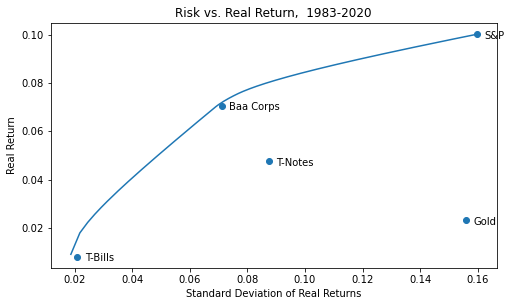

In [38]:
plot_efrontier(ret_df, df)


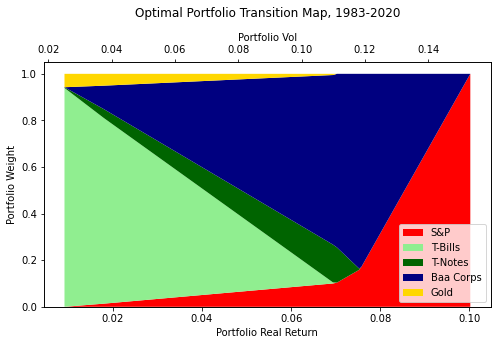

In [39]:
transition_map(ret_df, labels=df.columns, startyear=df.index[0], endyear=df.index[-1])

# Long/short optimization with leverage constraint

In [40]:
x1 = data_df['S&P'].values
n = len(x1)
target_corr = 0.6
theta = np.arccos(target_corr)
mean_return = -0.05
x2 = np.random.normal(0, x1.std(), size=n)  
# center so actual mean = 0
X = pd.DataFrame({'x1': x1 - x1.mean(),
                  'x2': x2 - x2.mean()
                 })
# identity matrix
Id = np.diag(np.ones(n))
# QR factorization 
Q, R = np.linalg.qr(X[['x1']])
P = Q @ Q.T
x2o = (Id - P) @ X[['x2']]
Xc2 = pd.DataFrame({'x1': X['x1'], 'x2': x2o['x2']})
# divide by l2 norm
Y = Xc2 / np.sqrt(np.sum(np.square(Xc2)))
retval = Y['x2'] + (1/np.tan(theta)) * Y['x1'] + mean_return


In [41]:
# in order to include shorts, we need an asset with a negative expected return
n = len(data_df)
target_corr = 0.6
def target_corr(x1, target_corr, mean_return):
    """given a series x1, return a random series with correlation target_corr to x1"""
    n = len(x1)
    theta = np.arccos(target_corr)
    
    x2 = np.random.normal(0, x1.std(), size=n)  
    # center so actual mean = 0
    X = pd.DataFrame({'x1': x1 - x1.mean(),
                      'x2': x2 - x2.mean()
                     })
    # identity matrix
    Id = np.diag(np.ones(n))
    # QR factorization
    Q = np.linalg.qr(X[['x1']])[0]
    P = Q @ Q.T
    x2o = (Id - P) @ X[['x2']]
    Xc2 = pd.DataFrame({'x1': X['x1'], 'x2': x2o['x2']})
    # divide by l2 norm
    Y = Xc2 / np.sqrt(np.sum(np.square(Xc2)))
    return Y['x2'] + (1/np.tan(theta)) * Y['x1'] + mean_return

stonks = target_corr(data_df['S&P'].values, 0.9, -0.05)
print("mean return %.04f" % stonks.mean())
print("vol %.04f" % stonks.std())
np.corrcoef(stonks, data_df['S&P'])



mean return -0.0500
vol 0.2392


array([[1. , 0.9],
       [0.9, 1. ]])

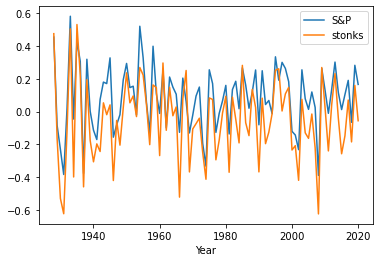

In [42]:
data_df['stonks'] = stonks.to_list()
labels = ['S&P', 'T-Bills', 'T-Notes', 'Baa Corps', 'Gold', 'stonks']

df = data_df
df[['S&P', 'stonks']].plot.line();

In [43]:
# compute covariance matrix
Sigma = np.cov(df.transpose())
# number of assets

n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T @ w 
# volatility
vol = cp.quad_form(w, Sigma)

z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

,S&P,T-Bills,T-Notes,Baa Corps,Gold,stonks
rows,,,,,,
real return,0.085008,0.004174,0.022511,0.042692,0.037508,-0.050000
vol,0.195308,0.035575,0.081235,0.085938,0.214255,0.239182


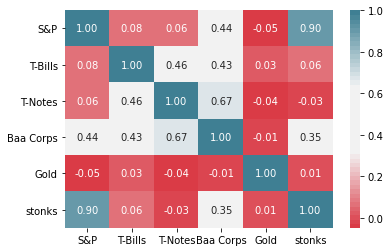

In [44]:
my_cmap = sns.diverging_palette(10, 220, sep=80, n=50)
sns.heatmap(df.corr(), annot=True, fmt=".02f", cmap=my_cmap);


In [45]:
# Solve max return portfolio (corner solution)
# update constraints for leverage scenario
# sum of weights == 1 as before, net long 100%
# remove w >= 0 constraint
# new constraint on gross exposure <= 1.5, otherwise optimal weights are unbounded (go infinity long S&P, infinity short stonks)

prob = cp.Problem(cp.Maximize(ret), 
                  [cp.norm1(w) <= 1.5,
                   cp.sum(w) == 1]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxret = ret.value
print("Max return portfolio weights (return=%.4f, vol=%.4f)" % (maxret, maxretvol))
pd.DataFrame([wts], columns=labels)


Max return portfolio weights (return=0.1188, vol=0.0369)


,S&P,T-Bills,T-Notes,Baa Corps,Gold,stonks
0,1.25,-0.0,0.0,0.0,0.0,-0.25


In [46]:
# solve min vol portfolio (other corner solution)
prob = cp.Problem(cp.Minimize(vol),
                  [cp.norm1(w) <= 1.5,
                   cp.sum(w) == 1]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]

minvol = vol.value
minvolret = ret.value
print("Min vol portfolio weights (return=%.4f, vol=%.4f)" % (minvolret, minvol))
pd.DataFrame([wts], columns=labels)


Min vol portfolio weights (return=0.0078, vol=0.0012)


,S&P,T-Bills,T-Notes,Baa Corps,Gold,stonks
0,0.0455,0.9814,0.016,-0.0513,0.0236,-0.0152


In [47]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret), 
                  [cp.norm1(w) <= 1.5,
                   cp.sum(w) == 1,
                   vol <= vol_limit]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


CPU times: user 402 ms, sys: 3.24 ms, total: 405 ms
Wall time: 403 ms


In [48]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]
ret_df


,i,vol,return,std,S&P,T-Bills,T-Notes,Baa Corps,Gold,stonks
0,0,0.001218,0.007794,0.034896,0.045616,9.813918e-01,1.600909e-02,-5.129162e-02,2.357907e-02,-0.015304
1,1,0.001397,0.027772,0.037377,0.192203,9.292318e-01,-1.117313e-02,-1.037564e-02,3.719569e-02,-0.137082
2,2,0.001576,0.036052,0.039704,0.252952,9.075572e-01,-2.240037e-02,6.583788e-03,4.284634e-02,-0.187539
3,3,0.001756,0.042401,0.041901,0.299960,8.867604e-01,-2.421195e-02,1.588047e-02,4.739836e-02,-0.225788
4,4,0.001935,0.047551,0.043989,0.336708,8.381809e-01,3.188021e-08,2.165878e-02,5.345189e-02,-0.250000
...,...,...,...,...,...,...,...,...,...,...
195,195,0.036184,0.118328,0.190220,1.240898,3.265013e-10,7.131327e-10,1.484818e-09,9.101646e-03,-0.250000
196,196,0.036363,0.118437,0.190691,1.243191,2.759273e-10,5.947440e-10,1.190692e-09,6.808793e-03,-0.250000
197,197,0.036542,0.118545,0.191160,1.245472,4.980678e-09,1.021365e-08,1.771479e-08,4.527678e-03,-0.250000
198,198,0.036722,0.118653,0.191629,1.247742,1.825458e-09,3.350371e-09,4.904493e-09,2.258146e-03,-0.250000


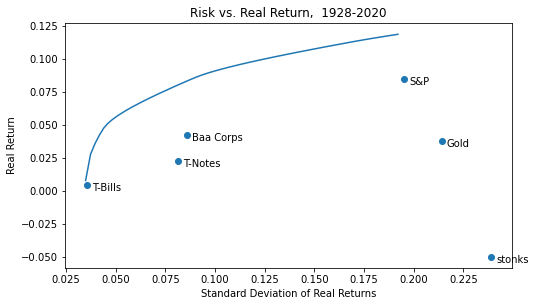

In [49]:
plot_efrontier(ret_df, df)


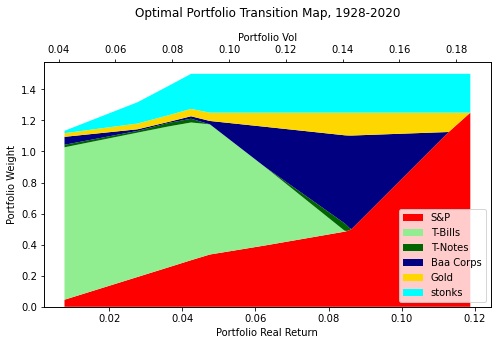

In [50]:
transition_map(ret_df, labels=df.columns, startyear=df.index[0], endyear=df.index[-1])
# these are absolute values, there are shorts

# Factors

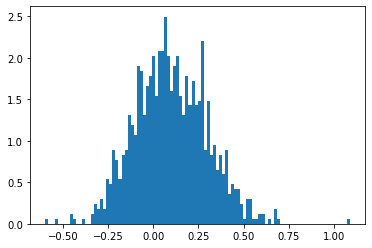

In [51]:
# number of stocks
n = 1000 
# historical mean returns for each stock
mu = np.random.normal(0.1, 0.2, n)

# number of factors
m = 10

# factor covariance matrix - random symmetrical matrix
SigmaFactor = np.random.randn(m, m)/4
SigmaFactor = SigmaFactor.T @ SigmaFactor

# factor loadings, determine volatility and covariances between stocks
F = np.random.randn(n, m)
# idiosyncratic risk of each stock
D = np.diag(np.random.uniform(0, 0.9, size=n))

count, bins, ignored = plt.hist(mu, 100, density=True, align='mid')


In [52]:
w = cp.Variable(n)         # what we solve for: weight for each stock
ret = mu.T @ w             # solve for weights that maximize portfolio return
f = F.T @ w                # portfolio factor loading
Lmax = cp.Parameter()      # leverage constraint
# portfolio volatility: factor risk + idiosyncratic risk
risk = cp.quad_form(f, SigmaFactor) + cp.quad_form(w, D)
prob = cp.Problem(cp.Maximize(ret), 
                  [cp.sum(w) == 1, 
                   cp.norm(w, 1) <= Lmax])

# Solve the factor model problem.
Lmax.value = 2
prob.solve(verbose=True)

maxretvol = risk.value
maxret = ret.value
print("Max return portfolio (return=%.4f, vol=%.4f)" % (maxret, maxretvol))



ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -9.798e-02  -3.087e+00  +4e+01  2e-01  6e-01  1e+00  2e-02    ---    ---    1  1  - |  -  - 
 1  -2.137e-01  -1.045e+00  +3e+01  7e-02  3e-01  8e-01  1e-02  0.2887  3e-01   0  0  0 |  0  0
 2  -1.063e+00  -1.920e+00  +3e+01  3e-02  4e-01  1e+00  1e-02  0.0179  1e+00   0  0  0 |  0  0
 3  -1.452e+00  -1.581e+00  +1e+01  5e-03  1e-01  5e-01  6e-03  0.6227  6e-02   0  0  0 |  0  0
 4  -1.488e+00  -1.618e+00  +8e+00  4e-03  9e-02  3e-01  5e-03  0.3179  3e-01   1  1  1 |  0  0
 5  -1.510e+00  -1.642e+00  +8e+00  4e-03  9e-02  3e-01  5e-03  0.0196  9e-01   1  1  1 |  0  0
 6  -1.779e+00  -1.903e+00  +3e+00  1e-03  3e-02  4e-02  2e-03  0.9890  4e-01   1  0  1 |  0  0
 7  -1.922e+00  -1.926e+00  +1e-01  4e-05  1e-03  9e-04  6e-05  0.9722  7e-03   1  1  1 |  0  0
 8  -1.929e+00  -1.929e+00  +1e-03  4e-07  1e-

In [53]:
# solve min vol portfolio (other corner solution)

prob = cp.Problem(cp.Minimize(risk),
                  [cp.sum(w) == 1, 
                   cp.norm(w, 1) <= Lmax])
prob.solve(solver=cp.OSQP)

minvol = risk.value
minvolret = ret.value
print("Min vol portfolio (return=%.4f, risk=%.4f)" % (minvolret, minvol))


Min vol portfolio (return=0.1163, risk=0.0002)


In [54]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   cp.norm(w, 1) <= Lmax,
                   risk <= vol_limit]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve(verbose=False)
    return (ret.value, np.sqrt(risk.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


/Users/drucev/opt/anaconda3/envs/portfolio_opt/lib/python3.7/site-packages/cvxpy/problems/problem.py:1061: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


CPU times: user 58.6 s, sys: 461 ms, total: 59.1 s
Wall time: 7.46 s


In [55]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'var']
ret_df['return'] = [results_dict[v][0] for v in ret_df['var']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['var']]
ret_df


,i,var,return,std
0,0,0.000179,0.143015,0.013489
1,1,0.058397,1.200083,0.241656
2,2,0.116616,1.306034,0.341490
3,3,0.174834,1.361601,0.418131
4,4,0.233052,1.396435,0.482754
...,...,...,...,...
195,195,11.352716,1.925922,3.369379
196,196,11.410934,1.926846,3.378007
197,197,11.469152,1.927656,3.386614
198,198,11.527371,1.928385,3.395198


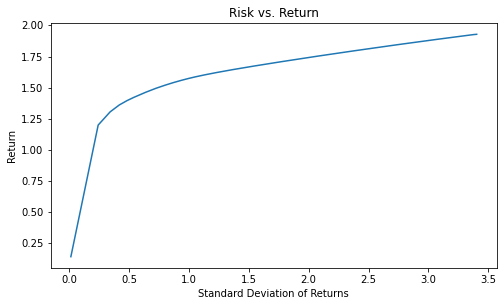

In [56]:
# plot frontier
plt.figure(figsize=(8, 4.5))
#plt.scatter(asset_vols, mu)

x = ret_df['std']
y = ret_df['return']
plt.xlabel("Standard Deviation of Returns")
plt.ylabel("Return")
plt.title("Risk vs. Return")

# plot the data
plt.plot(x,y);


In [57]:
#TRIALS

In [58]:
def trial(vol=0,
          startval=1025000,
          spend=50000,
          ret_expected=0.0,
          vol_expected=0.0, 
          verbose=False):

    year = 0
    val = startval
    while val > 0:
        if verbose:
            print("year %-2d: %8.0f" % (year, val))
        ret = np.random.normal(loc=ret_expected,
                               scale=vol_expected)
        val -= spend
        # lognormal distribution
        val = np.exp(np.log(val) + ret) if val > 0 else 0
        val = max(0, val)
        year += 1

    if verbose:
        print("year %-2d: %8.0f" % (year, val))
        
    return(year)

trial(vol_expected=0.0, verbose=True)


year 0 :  1025000
year 1 :   975000
year 2 :   925000
year 3 :   875000
year 4 :   825000
year 5 :   775000
year 6 :   725000
year 7 :   675000
year 8 :   625000
year 9 :   575000
year 10:   525000
year 11:   475000
year 12:   425000
year 13:   375000
year 14:   325000
year 15:   275000
year 16:   225000
year 17:   175000
year 18:   125000
year 19:    75000
year 20:    25000
year 21:        0


21